In [1]:
import torch
from datasets import load_mnist, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

BATCH_SIZE = 100
train_loader, test_loader, val_loader = load_mnist(BATCH_SIZE)

In [2]:
from models import SimpleVQVAE as VQVAE
import pytorch_lightning as pl

class VAETrainer(pl.LightningModule):
    def __init__(self):
        super(VAETrainer, self).__init__()
        
        self.model = VQVAE(128,16)
        
    def forward(self, x, x_cond, y):
        return self.model(x)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        #x_hat, quantized, latent, _ = self(x, x_cond, y)
        x_hat, vq_loss, encoding_indices = self(x, x_cond, y)
        #loss = self.model.loss(latent, quantized, x_hat, x)
        #self.log_dict({f"{mode}_{key}": val.item() for key, val in loss.items()}, sync_dist=True, prog_bar=True)
        self.log(f"{mode}_loss", vq_loss)
        return vq_loss
    
    def decode(self, z):
        return self.model.decode(z)
        
    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'train')
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'val')
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'test')
    
    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=1e-3)

In [3]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    dirpath='checkpoints/',
    filename='simple-vq-vae-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

logger = TensorBoardLogger('./', version="simple-vq_vae_50_2")

model = VAETrainer()

trainer = pl.Trainer(accelerator='gpu', devices=[5], max_epochs=30, enable_progress_bar=True, callbacks=[checkpoint_callback], logger=logger)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_checkpoint('checkpoints/simpel-vqvae_50.ckpt')

/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
You are using a CUDA device ('A100-S

Epoch 29: 100%|██████████| 600/600 [00:04<00:00, 121.01it/s, v_num=50_2]   

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 600/600 [00:04<00:00, 120.98it/s, v_num=50_2]


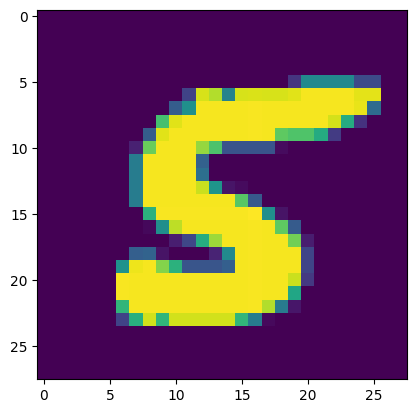

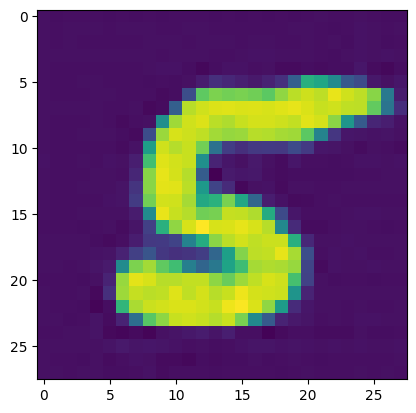

In [4]:
#print reconsturction and original image
model = VAETrainer.load_from_checkpoint('checkpoints/simpel-vqvae_50.ckpt')
x, _, _ = next(iter(val_loader))

x_hat, _, codes = model.model(x)

import matplotlib.pyplot as plt
plt.imshow(x[0, 0])
plt.show()
plt.imshow(x_hat[0, 0].detach())
plt.show()
